In [3]:
#Notebook's settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#from jupyterthemes import jtplot
#jtplot.reset()

# Plotting

import sys
Folder='/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/'
sys.path.append(Folder)


import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from skimage import measure
#%matplotlib inline


# Basic imports
import numpy as np
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
import math
import time

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)


#Fontsize
FS=18

/usr/local/Caskroom/miniforge/base/envs/env_jax/lib/python3.8/site-packages/jax/_src/lib/__init__.py:31: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [4]:
npix=100
pix_scl=0.08
k_vector=np.fft.fftfreq(npix,pix_scl)
kx,ky=np.meshgrid(k_vector,k_vector)
k_grid=np.sqrt(kx**2+ky**2)
nonsingular_k_grid=deepcopy(k_grid)
nonsingular_k_grid[0,0]=1

In [5]:
from GRF_perturbations.Modules.GRF_generation import Box_Muller_Fourier_phase_grid,Power_Spectrum,get_jaxified_GRF

In [6]:
from GRF_perturbations.Modules.grf_functions import *

In [21]:
def gauss_rand_2d (par):
    nx = par[0].astype(int)
    ny = par[1].astype(int)
    Lx = par[2]
    Ly = par[3]
    var = par[4]
    power = par[5]

    j= 0 + 1j # Defining the complex number
    plane = np.zeros ([nx, ny], dtype='clongdouble') # Empty matrix to be filled in for the Fourier plane

    #lxaxis = np.append (np.arange (0.,(nx/2.)/Lx, 1./Lx), np.arange ((-nx/2.)/Lx, 0.,1./Lx))
    #lyaxis = np.append (np.arange (0.,(ny/2.)/Ly, 1./Ly), np.arange ((-ny/2.)/Ly, 0.,1./Ly))

    resolution = float(Lx) / float(nx)
    lxaxis = np.fft.fftfreq (nx, resolution)
    lyaxis = np.fft.fftfreq (ny, resolution)

    Psum = Psum_calculator (nx, ny, Lx, Ly, power)

    for y in range(np.shape(plane)[0]):
        for x in range(np.shape(plane)[1]):
            # The coordinates centered at x = n/2, y = n/2
            i1 = x - nx/2
            j1 = y - ny/2 

            #The coordinates in the Fourier plane
            lx = lxaxis [x]
            ly = lyaxis [y]
            # The magnitude of the l-vector
            l = np.sqrt (lx**2. + ly**2.) 

            # Filling in the grid
            if x==0 and y==0: # average of the field
                plane[y][x] = 0.0
                continue
            
            # Polar Box-Muller transform
            sigma = math.sqrt(powspec(l, var, nx*ny, Psum, power))
            s = 1.1
            while (s >= 1.) or (s==0) :
                u = np.random.uniform (-1,1) 
                v = np.random.uniform (-1,1)
                
                nu=u
                nv=v
                
                s = nu**2. + nv**2.
            fac = math.sqrt(-2.*math.log(s)/s)
            z1 = u*fac*sigma
            z2 = v*fac*sigma

            

            # three points that need to be real valued to get a real image after FFT:
            if x== 0 and y==ny/2:
                plane[y][x] = z1
            elif x==nx/2 and y==0:
                plane[y][x] = z1
            elif x==nx/2 and y==ny/2:
                plane[y][x] = z1
            else :
                plane[y][x] = z1+j*z2

            # Creating symmetry f(k) = f*(-k)
            y2 = int( -(j1 + ny/2) )
            x2 = int( -(i1 + nx/2) )
        
            plane[y2][x2] = plane[y][x].conjugate()

        if y>np.shape(plane)[0]/2.:
            break
    return np.fft.ifftshift(np.fft.ifft2(plane)).real

In [22]:
    par=np.asarray([100,100,8,8,1,-beta])
    nx = par[0].astype(int)
    ny = par[1].astype(int)
    Lx = par[2]
    Ly = par[3]
    var = par[4]
    power = par[5]

In [197]:
np.random.seed(0)

In [389]:
def get_Fourier_phase(npix,seed):
    np.random.seed(seed)
    #rng=np.random.default_rng(seed)
    
    Fourier_phases = np.zeros ([npix, npix], dtype='cfloat') # Empty matrix to be filled in for the Fourier plane
    j= 0 + 1j # Defining the complex number
    
    for y in range(npix):
        for x in range(npix):
            
            # Filling in the grid
            if x==0 and y==0: # average of the field
                Fourier_phases[y,x] = 0.0
                continue
            '''
            # Polar Box-Muller transform
            s = 1.1
            while (s >= 1.) or (s==0) :
                u = np.random.uniform (-1,1) 
                v = np.random.uniform (-1,1)
                
                nu=u
                nv=v
                
                s = nu**2. + nv**2.
            #fac = math.sqrt(-2.*math.log(s)/s)
            fac=1/np.sqrt(s)
            z1 = u*fac
            z2 = v*fac
            '''
            
            phi=np.random.uniform(0,2*np.pi)
            z1=np.cos(phi)
            z2=np.sin(phi)
            

            # three points that need to be real valued to get a real image after FFT:
            if x== 0 and y==ny/2:
                Fourier_phases[y,x] = z1
            elif x==nx/2 and y==0:
                Fourier_phases[y,x] = z1
            elif x==nx/2 and y==ny/2:
                Fourier_phases[y,x] = z1
            else :
                Fourier_phases[y,x] = z1+j*z2

            Fourier_phases[-y,-x] = Fourier_phases[y,x].conjugate()

        if y>npix/2.:
            break
            
    return Fourier_phases

def Normalisation_Power(nonsingular_k_grid,beta):
    return np.power(nonsingular_k_grid,-beta).sum()-1

def sqrt_Power_spectrum(nonsingular_k_grid,variance,beta):
    Normalisation=np.power(nonsingular_k_grid.size,2)/(Normalisation_Power(nonsingular_k_grid,beta))
    Amplitude=np.sqrt(variance*Normalisation)
    sqrt_Power_spectrum=Amplitude*np.power(nonsingular_k_grid,-beta/2)
    #Zero mean
    sqrt_Power_spectrum[0,0]=0.
    
    return sqrt_Power_spectrum

def generate_GRF(nonsingular_k_grid,variance,power_slope,Fourier_phases):
    #Fourier_phases=get_Fourier_phase(nonsingular_k_grid.shape[0],seed)
    sqrt_Pow_spec=sqrt_Power_spectrum(nonsingular_k_grid,variance,power_slope)
    
    Fourier_image=sqrt_Pow_spec*Fourier_phases
    GRF=np.fft.ifft2(Fourier_image).real
    
    return GRF

In [267]:
rng=np.random.default_rng(0)

In [290]:
np.where((sq_PS<1))[0].shape

(8031,)

In [285]:
sq_PS.max()

3134.1200742982637

In [284]:
sq_PS.min()

0.07454235783256703

In [281]:
k_grid[:5,:5]

array([[0.        , 0.125     , 0.25      , 0.375     , 0.5       ],
       [0.125     , 0.1767767 , 0.2795085 , 0.39528471, 0.5153882 ],
       [0.25      , 0.2795085 , 0.35355339, 0.45069391, 0.55901699],
       [0.375     , 0.39528471, 0.45069391, 0.53033009, 0.625     ],
       [0.5       , 0.5153882 , 0.55901699, 0.625     , 0.70710678]])

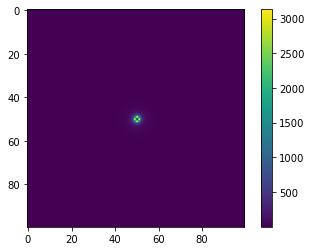

In [278]:
plt.imshow(np.fft.fftshift(sq_PS))
plt.colorbar()

In [228]:
sq_PS=sqrt_Power_spectrum(nonsingular_k_grid,1,5)

0.999999998787999


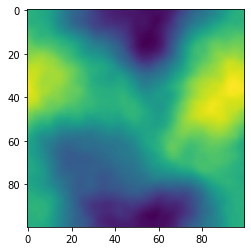

In [375]:
seed=4
beta=5
Fourier_phases=get_Fourier_phase(100,seed)
GRF=generate_GRF(nonsingular_k_grid,1,beta,Fourier_phases)
plt.imshow(GRF)
print(GRF.var())

In [381]:
variables=np.zeros(300)

for i in tqdm(range(300)):
    Fourier_phases=get_Fourier_phase(100,i)
    GRF=generate_GRF(nonsingular_k_grid,1,beta,Fourier_phases)
    variables[i]=GRF[0,0]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:09<00:00, 32.52it/s]


(array([ 4.,  1.,  5.,  9., 12., 19., 27., 22., 20., 30., 26., 25., 20.,
        23., 14., 15., 17.,  6.,  2.,  3.]),
 array([-2.45481935, -2.21210309, -1.96938684, -1.72667058, -1.48395432,
        -1.24123807, -0.99852181, -0.75580555, -0.5130893 , -0.27037304,
        -0.02765678,  0.21505948,  0.45777573,  0.70049199,  0.94320825,
         1.1859245 ,  1.42864076,  1.67135702,  1.91407327,  2.15678953,
         2.39950579]),
 <BarContainer object of 20 artists>)

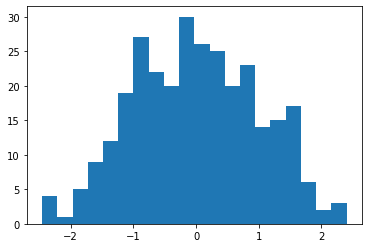

In [382]:
plt.hist(variables,bins=20)

In [383]:
variables.mean()

0.004086936446904392

In [384]:
variables.std()**2

0.9843185625699783

In [390]:
GRFs=np.zeros((100,100,100))
for i in tqdm(range(100)):
    Fourier_phases=get_Fourier_phase(100,i)
    GRF=generate_GRF(nonsingular_k_grid,1,beta,Fourier_phases)
    GRFs[i]=GRF

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.35it/s]


In [391]:
GRFs.var(axis=(1,2))

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
nonsingular_k_grid

In [ ]:
Obs

In [387]:
def generate_data(GRF_params,GRF_seed,Observation_conditions,fit=True,Noise_flag=True):

    #Specifics of Observation_conditions
    get_GRF=Observation_conditions.GRF_getter()
    simulate_perturbed_image=Observation_conditions.perturbed_image_getter
    parameters=Observation_conditions.parameters
    simulate_unperturbed_image=Observation_conditions.unperturbed_image_getter
    simulate_unperturbed_image_pure=lambda kwargs: simulate_unperturbed_image(kwargs,Noise_flag=False)
    differentiable_fit_image_pure=purify_function(differentiable_fit_image,simulate_unperturbed_image_pure,\
                                                  parameters.kwargs2args(Observation_conditions.kwargs_data),Observation_conditions.noise_var,parameters,1000,1e-4)
    compute_radial_spectrum_pure=purify_function(compute_radial_spectrum,Observation_conditions.annulus_mask,Observation_conditions.init_freq_index)

    #this is the true perturbation of the lens potential
    GRF_potential=get_GRF(GRF_params,GRF_seed)

    #data_image will play the role of the observed lens, that we are going to study
    data_image=simulate_perturbed_image(GRF_potential,Observation_conditions.kwargs_data,Noise_flag=Noise_flag,noise_seed=42)
    #Fit the data_image with unperturbed lens-source model to get a guess of kwargs_data, since we don't know them initially
    #One might use sophisticated trust-krylov optimization but it was found that grad_descent converge to the same values anyway

    if fit:
        fit_image=differentiable_fit_image_pure(data_image)
    else:
        fit_image=simulate_unperturbed_image_pure(Observation_conditions.kwargs_data)

    data_resid_spectrum=compute_radial_spectrum_pure(data_image-fit_image)


    return GRF_potential,data_image,fit_image,data_resid_spectrum

In [388]:
from GRF_perturbations.Modules.Data_generation import Observation_conditions_class

ImportError: cannot import name 'get_jaxified_GRF_true_var' from 'GRF_perturbations.Modules.GRF_generation' (/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/GRF_perturbations/Modules/GRF_generation.py)

In [294]:
GRF.var()

1.040690727886448

In [299]:
GRF.mean()

-2.2737367544323207e-17

In [301]:
variances.max(axis=-1)

array([2.36845527, 2.36845527, 2.36845527, 2.36845527, 2.36845527,
       2.36845527, 2.36845527, 2.36845527, 2.36845527, 2.36845527,
       2.36845527, 2.36845527, 2.36845527, 2.36845527, 2.36845527,
       2.36845527, 2.36845527, 2.36845527, 2.36845527, 2.36845527])

In [306]:
np.fft.fftfreq(100,0.08)

array([ 0.   ,  0.125,  0.25 ,  0.375,  0.5  ,  0.625,  0.75 ,  0.875,
        1.   ,  1.125,  1.25 ,  1.375,  1.5  ,  1.625,  1.75 ,  1.875,
        2.   ,  2.125,  2.25 ,  2.375,  2.5  ,  2.625,  2.75 ,  2.875,
        3.   ,  3.125,  3.25 ,  3.375,  3.5  ,  3.625,  3.75 ,  3.875,
        4.   ,  4.125,  4.25 ,  4.375,  4.5  ,  4.625,  4.75 ,  4.875,
        5.   ,  5.125,  5.25 ,  5.375,  5.5  ,  5.625,  5.75 ,  5.875,
        6.   ,  6.125, -6.25 , -6.125, -6.   , -5.875, -5.75 , -5.625,
       -5.5  , -5.375, -5.25 , -5.125, -5.   , -4.875, -4.75 , -4.625,
       -4.5  , -4.375, -4.25 , -4.125, -4.   , -3.875, -3.75 , -3.625,
       -3.5  , -3.375, -3.25 , -3.125, -3.   , -2.875, -2.75 , -2.625,
       -2.5  , -2.375, -2.25 , -2.125, -2.   , -1.875, -1.75 , -1.625,
       -1.5  , -1.375, -1.25 , -1.125, -1.   , -0.875, -0.75 , -0.625,
       -0.5  , -0.375, -0.25 , -0.125])

In [329]:
Normalisation=np.power(nonsingular_k_grid.size,2)/(2.*Normalisation_Power(nonsingular_k_grid,5))

In [331]:
(PS/Normalisation/Normalisation_Power(nonsingular_k_grid,5)).sum()

1.0

In [335]:
true_PS=np.power(sqrt_Power_spectrum(nonsingular_k_grid,1,5),2)
Fourier_image=sqrt_Power_spectrum(nonsingular_k_grid,1,5)*Fourier_phases_main
PS=np.abs(Fourier_image)**2

In [360]:
betas=np.linspace(0.1,5,20)
variances=np.zeros((20,20))

for i,beta in tqdm(enumerate(betas)):
    for j in range(variances.shape[1]):
        Fourier_phases=get_Fourier_phase(npix,j)
        
        phases=deepcopy(Fourier_phases)
        
        #phases[0,1]=Fourier_phases_main[0,1]
        #phases[1,0]=Fourier_phases_main[1,0]
        #phases[-1,0]=Fourier_phases_main[-1,0]
        #phases[0,-1]=Fourier_phases_main[0,-1]
        
        
        
        GRF=generate_GRF(nonsingular_k_grid,1,beta,phases)
        
        variances[i,j]=GRF.var()

20it [00:12,  1.62it/s]


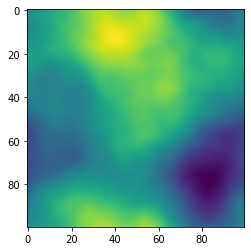

In [342]:
plt.imshow(GRF)

In [363]:
variances.mean(axis=-1)

array([0.99986656, 0.9998836 , 0.99990079, 0.99991807, 0.99993521,
       0.9999517 , 0.99996667, 0.99997907, 0.99998815, 0.99999393,
       0.99999714, 0.99999874, 0.99999947, 0.99999979, 0.99999992,
       0.99999997, 0.99999999, 1.        , 1.        , 1.        ])

<function matplotlib.pyplot.show(close=None, block=None)>

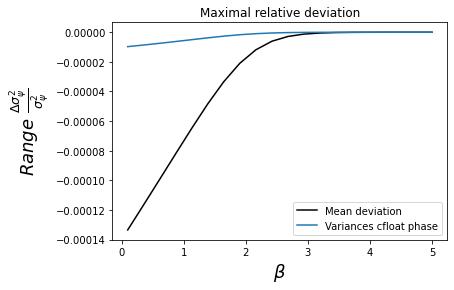

In [361]:
#plt.hlines(0,betas[0],betas[-1],label='Expected variance',color='C1')
plt.plot(betas,(variances.mean(axis=1)-1),label='Mean deviation',color='k')
plt.plot(betas,(variances.max(axis=1)-1),label='Variances cfloat phase')
plt.xlabel(r'$\beta$',fontsize=FS)
plt.ylabel(r'$Range \ \frac{\Delta \sigma^2_{\psi}}{\sigma^2_{\psi}}$',fontsize=FS)

plt.title('Maximal relative deviation')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

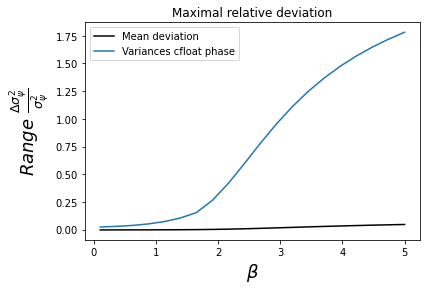

In [272]:
#plt.hlines(0,betas[0],betas[-1],label='Expected variance',color='C1')
plt.plot(betas,(variances.mean(axis=1)-1),label='Mean deviation',color='k')
plt.plot(betas,(variances.max(axis=1)-1),label='Variances cfloat phase')
plt.xlabel(r'$\beta$',fontsize=FS)
plt.ylabel(r'$Range \ \frac{\Delta \sigma^2_{\psi}}{\sigma^2_{\psi}}$',fontsize=FS)

plt.title('Maximal relative deviation')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

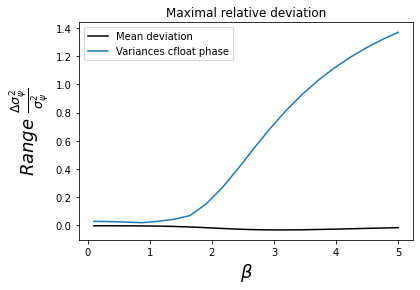

In [264]:
#plt.hlines(0,betas[0],betas[-1],label='Expected variance',color='C1')
plt.plot(betas,(variances.mean(axis=1)-1),label='Mean deviation',color='k')
plt.plot(betas,(variances.max(axis=1)-1),label='Variances cfloat phase')
plt.xlabel(r'$\beta$',fontsize=FS)
plt.ylabel(r'$Range \ \frac{\Delta \sigma^2_{\psi}}{\sigma^2_{\psi}}$',fontsize=FS)

plt.title('Maximal relative deviation')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

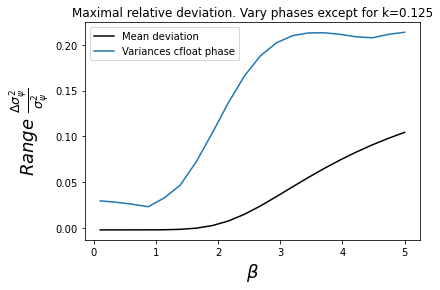

In [258]:
#plt.hlines(0,betas[0],betas[-1],label='Expected variance',color='C1')
plt.plot(betas,(variances.mean(axis=1)-1),label='Mean deviation',color='k')
plt.plot(betas,(variances.max(axis=1)-1),label='Variances cfloat phase')
plt.xlabel(r'$\beta$',fontsize=FS)
plt.ylabel(r'$Range \ \frac{\Delta \sigma^2_{\psi}}{\sigma^2_{\psi}}$',fontsize=FS)

plt.title('Maximal relative deviation. Vary phases except for k=0.125')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

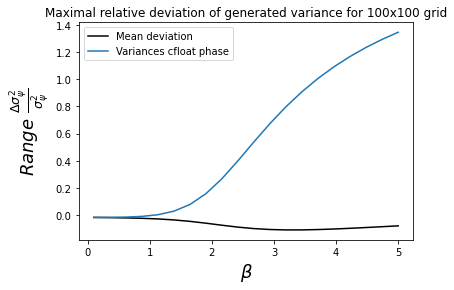

In [253]:
#plt.hlines(0,betas[0],betas[-1],label='Expected variance',color='C1')
plt.plot(betas,(variances.mean(axis=1)-1),label='Mean deviation',color='k')
plt.plot(betas,(variances.max(axis=1)-1),label='Variances cfloat phase')
plt.xlabel(r'$\beta$',fontsize=FS)
plt.ylabel(r'$Range \ \frac{\Delta \sigma^2_{\psi}}{\sigma^2_{\psi}}$',fontsize=FS)

plt.title('Maximal relative deviation of generated variance for 100x100 grid')
plt.legend()
plt.show

In [241]:
variances.mean(axis=-1)

array([0.99800294, 0.99791425, 0.99763143, 0.99697831, 0.99565994,
       0.99328556, 0.98953937, 0.98451452, 0.9789461 , 0.97395643,
       0.97044399, 0.96871965, 0.968605  , 0.96970818, 0.97162482,
       0.97402293, 0.97665814, 0.97936198, 0.98202399, 0.98457554])

In [ ]:
#variances_nonzero_mean=deepcopy(variances)
#variances_clongdouble_phase=deepcopy(variances)
#variances_cfloat_phase==deepcopy(variances)

<function matplotlib.pyplot.show(close=None, block=None)>

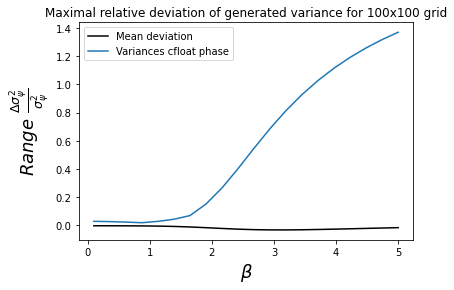

In [242]:
#plt.hlines(0,betas[0],betas[-1],label='Expected variance',color='C1')
plt.plot(betas,(variances.mean(axis=1)-1),label='Mean deviation',color='k')
plt.plot(betas,(variances.max(axis=1)-1),label='Variances cfloat phase')
plt.xlabel(r'$\beta$',fontsize=FS)
plt.ylabel(r'$Range \ \frac{\Delta \sigma^2_{\psi}}{\sigma^2_{\psi}}$',fontsize=FS)

plt.title('Maximal relative deviation of generated variance for 100x100 grid')
plt.legend()
plt.show

In [161]:
variances_nonzero_mean=deepcopy(variances)
#variances_clongdouble_phase=deepcopy(variances)
#variances_cfloat_phase==deepcopy(variances)

<function matplotlib.pyplot.show(close=None, block=None)>

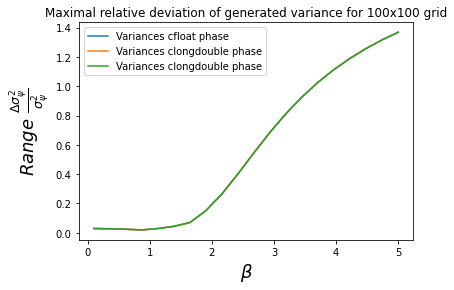

In [162]:
#plt.hlines(0,betas[0],betas[-1],label='Expected variance',color='C1')
#plt.plot(betas,(variances.mean(axis=1)-1),label='Generated variance',color='C0')
#plt.fill_between(betas,(variances.min(axis=1)-1),(variances.max(axis=1)-1),alpha=0.1)
plt.plot(betas,(variances_cfloat_phase.max(axis=1)-1),label='Variances cfloat phase')
plt.plot(betas,(variances_clongdouble_phase.max(axis=1)-1),label='Variances clongdouble phase')
plt.plot(betas,(variances_nonzero_mean.max(axis=1)-1),label='Variances clongdouble phase')
plt.xlabel(r'$\beta$',fontsize=FS)
plt.ylabel(r'$Range \ \frac{\Delta \sigma^2_{\psi}}{\sigma^2_{\psi}}$',fontsize=FS)

plt.title('Maximal relative deviation of generated variance for 100x100 grid')
plt.legend()
plt.show